# Predicting Wine Cultivars

<br><br>

## Summary
---
In this project, we will predict what cultivar a wine was derived from based on its chemical properties.  

The data was sourced from the [UCI Machine Learning Repository](https://doi.org/10.24432/C5PC7J). It contains data about various wines from Italy derived from three different cultivars. Each row represents the chemical and physical properties of a different wine, such as its concentration of alcohol, magnesium level and hue. 

<br>

## Introduction
---
Wine is a beverage that has been enjoyed by humans for thousands of years (Feher et al. 2007). Consequently, humans have a long agricultural history with the grape plant which has led to the development of many different cultivars: grape plants selected and breed for their desirable characteristics (Harutyunyan and Malfeito-Ferreira 2022). Our dataset contains information about twelve chemical properties of 178 red wines made from three grape cultivars in Italy. 

The recorded chemical properties include: 
1. Alcohol content
2. Malic acid (gives the wine a fruity flavour)
3. Ash (left over inorganic matter from the wine-making process)
4. Alkalinity of ash (ability to resist acidification)
5. Magnesium, total phenols (contribute to bitter flavour of wine)
6. Flavanoids (antioxidants that contribute to bitter flavour and aroma of wine)
7. Nonflavanoid phenols (weakly acidic)
8. Proanthocyanins (bitter smell)
9. Color intensity
10. Hue
11. The ratio of OD280 to OD315 of diluted wines (protein concentration)
12. Proline (main amino acid in wine, important aspect of the flavour) (Bai et al. 2019).

Using this dataset, our predictive question is: **"What is the cultivar of an unknown wine based on the chemical properties?"** 

Identifying the chemical properties that distinguish cultivars enables farmers to make informed decisions about grape cultivation, aligning grape varieties with desired wine characteristics. By selecting cultivars known for specific flavor profiles or chemical compositions, farmers can tailor vineyard practices to meet market demands effectively. Moreover, this knowledge empowers brewers to experiment with wine compositions, fostering innovation and the creation of novel flavors. Armed with a deep understanding of wine chemistry, brewers can also strategically market their products, ensuring effective communication of the unique qualities and appeal of each wine to consumers.

<br>

## Code and Analysis
---

In [2]:
# imports and libraries 
#library(GGally) # for ggpairs
library(tidyverse) #importing tidyverse
library(tidymodels) # importing tidymodels
library(repr)
library(gridExtra)
library(kknn)
library(dplyr) # for data wrangling
library(knitr) # to create tables
library(themis) # to balance our cultivar classes out

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.1      ✔ tune         1.1.2 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.0.1 
✔ parsnip      1.2.0      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ 

In [2]:
# Reading in the data from the web
set.seed(5)

raw_data <- read.csv("https://raw.githubusercontent.com/DSCI-310-2024/DSCI-310-Group-5/qmd_doc/data/wine.csv")
head(raw_data)
# raw_data$cultivar <- as.factor(raw_data$cultivar )
# write_csv(raw_data, "../data/wine.csv")

,cultivar,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,X0D280_0D315_ratio,proline
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
2,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
3,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
5,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
6,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [3]:
# head(raw_data)
na_count <- nrow(raw_data) - sum(complete.cases(raw_data))
na_count

[1] 0

<br><br>

## Exploratory Data Analysis

In [4]:
# EDA: use a plot to see the relationships between variables
# options(repr.plot.width = 20, repr.plot.height = 20) # format the any visualizations to be easily viewable
# pairplots <- raw_data %>%
#   ggpairs(progress = FALSE) +
#   theme(
#     text = element_text(size = 15),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   )
# pairplots

Figure 1: A correlation matrix for the variables in our dataset.

<br>

In [5]:
# Check the number of observations per cultivar
sample_size_cultivar <- raw_data %>%
    group_by(cultivar) %>%
    summarize(sample_size = n())

sample_size_cultivar # class 2 has more observations than the other classes -> need to balance the classes out

cultivar,sample_size
<int>,<int>
1,59
2,71
3,48


Table 1: The number of observations for each level of `cultivar` before balancing.

<br>

In [6]:
# balance the cultivar class 

# convert cultivar into a factor
raw_data <- raw_data |>
  mutate(cultivar = as.factor(cultivar))

# recipe for balancing
cultivar_balance_recipe <- recipe(cultivar ~ ., data = raw_data) |>
  step_upsample(cultivar, over_ratio = 1, skip = FALSE) |>
  prep()

# execute the balancing
data <- bake(cultivar_balance_recipe, raw_data)

# check the data is balanced
balanced_data <- data |>
  group_by(cultivar) |>
  summarize(n = n())

balanced_data # data has been upsampled so all groups have equal sample size


cultivar,n
<fct>,<int>
1,71
2,71
3,71


Table 2: The number of observations for each level of `cultivar` after balancing.

<br>

In [7]:
# calculate the mean for each cultivar group
cultivar_mean_table <- raw_data |>
    group_by(cultivar) |>
    summarize(across(alcohol:proline, mean, na.rm = TRUE))

cultivar_mean_table <- cultivar_mean_table %>% 
                      mutate(stat = 'mean') %>%
                      select(stat, everything())

 
# calculate the standard deviation for each cultivar group
cultivar_sd_table <- raw_data |>
    group_by(cultivar) |>
    summarize(across(alcohol:proline, sd, na.rm = TRUE))

cultivar_sd_table <- cultivar_sd_table %>% 
                      mutate(stat = 'sd') %>%
                      select(stat, everything())

# calculate the maximum values for each cultivar group
cultivar_max_table <- data %>%
  group_by(cultivar) %>%
  summarize(across(alcohol:proline, ~max(.x, na.rm = TRUE))) %>%  # Corrected line
  mutate(stat = 'max') %>%
  select(stat, everything())

# # calculate the minimum values for each cultivar group
cultivar_min_table <- raw_data |>
    group_by(cultivar) |>
    summarize(across(alcohol:proline, min, na.rm = TRUE))

cultivar_min_table <- cultivar_min_table %>% 
                      mutate(stat = 'min') %>%
                      select(stat, everything())


appended_stats_df <- rbind(cultivar_mean_table,cultivar_sd_table, cultivar_max_table, cultivar_min_table)
appended_stats_df

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(alcohol:proline, mean, na.rm = TRUE)`.
ℹ In group 1: `cultivar = 1`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


stat,cultivar,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,X0D280_0D315_ratio,proline
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,1,13.7447458,2.0106780,2.4555932,17.037288,106.33898,2.8401695,2.9823729,0.29000000,1.8993220,5.5283051,1.0620339,3.1577966,1115.7119
mean,2,12.2787324,1.9326761,2.2447887,20.238028,94.54930,2.2588732,2.0808451,0.36366197,1.6302817,3.0866197,1.0562817,2.7853521,519.5070
mean,3,13.1537500,3.3337500,2.4370833,21.416667,99.31250,1.6787500,0.7814583,0.44750000,1.1535417,7.3962500,0.6827083,1.6835417,629.8958
sd,1,0.4621254,0.6885489,0.2271660,2.546322,10.49895,0.3389614,0.3974936,0.07004924,0.4121092,1.2385728,0.1164826,0.3570766,221.5208
sd,2,0.5379642,1.0155687,0.3154673,3.349770,16.75350,0.5453611,0.7057008,0.12396128,0.6020678,0.9249293,0.2029368,0.4965735,157.2112
sd,3,0.5302413,1.0879057,0.1846902,2.258161,10.89047,0.3569709,0.2935041,0.12413959,0.4088359,2.3109421,0.1144411,0.2721114,115.0970
max,1,14.3900000,4.0400000,3.2200000,25.000000,128.00000,3.8800000,3.9300000,0.47000000,2.9600000,8.7000000,1.2500000,4.0000000,1680.0000
max,2,13.8600000,5.8000000,3.2300000,30.000000,162.00000,3.5200000,5.0800000,0.66000000,3.5800000,6.0000000,1.7100000,3.6900000,985.0000
max,3,14.3400000,5.6500000,2.8600000,27.000000,122.00000,2.8000000,1.3900000,0.63000000,2.7000000,13.0000000,0.9600000,2.0600000,880.0000


Table 3: Summary statistics for each variable per cultivar.

<br>

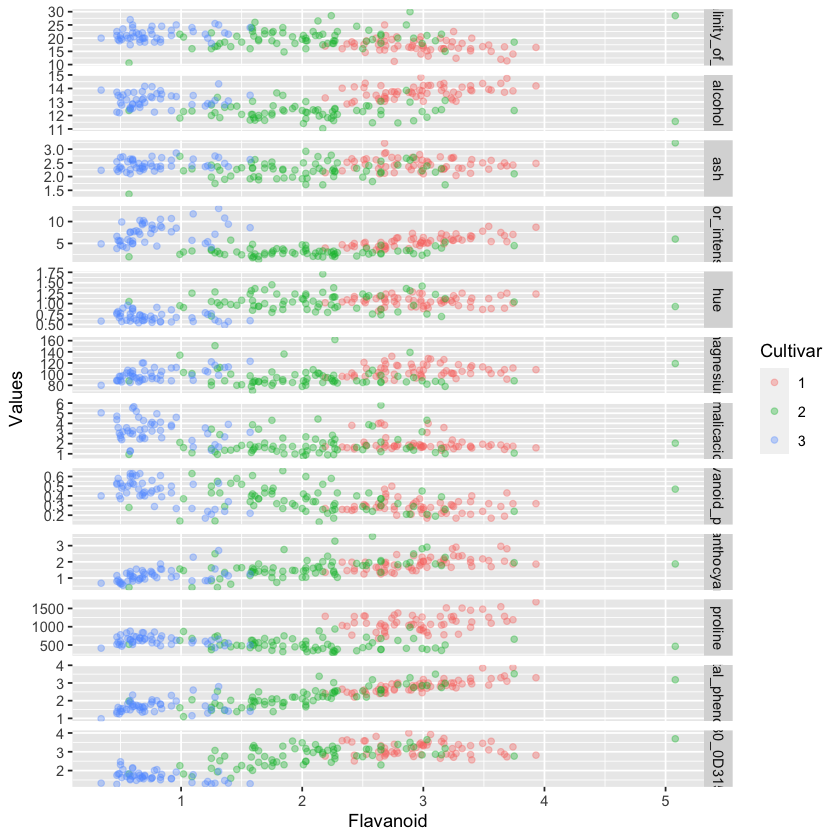

In [8]:
eda_plot_data <- raw_data |>
    relocate(flavanoids, 1)

eda_plot_data <- eda_plot_data |>
        pivot_longer(
        cols= alcohol:proline,
        names_to="factor",
        values_to="values")

eda_plot1 <- eda_plot_data|>
    ggplot(aes(x=flavanoids,y=values,color=cultivar))+
    geom_point(alpha=0.35)+
    facet_grid(factor~.,scales="free")+
    labs(x="Flavanoid",y="Values",color="Cultivar")
eda_plot1


Figure 2: Colourizing `cultivar` for each variable in the dataset to visualize patterns in the data.

<br>

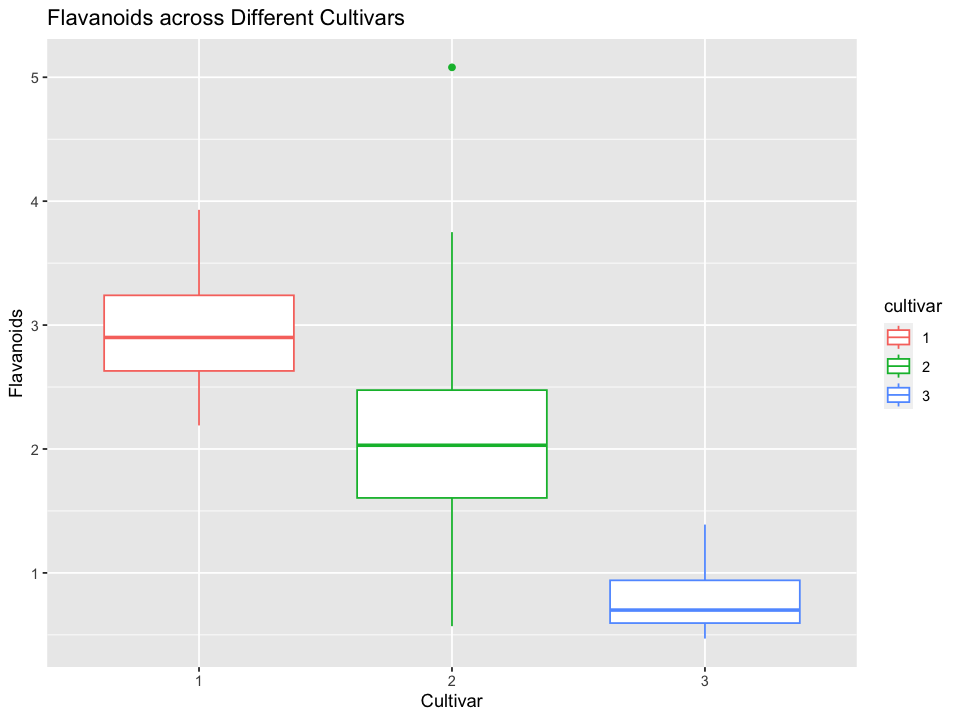

In [9]:
# Selecting flavanoids as a variable for visualization
options(repr.plot.width = 8, repr.plot.height = 6)

# Create a boxplot using ggplot2
ggplot(data, aes(x = cultivar, y = flavanoids, color = cultivar)) +
  geom_boxplot() +
  labs(title = "Flavanoids across Different Cultivars", x = "Cultivar", y = "Flavanoids")

Figure 3. Boxplot of the flavanoid values for each cultivar

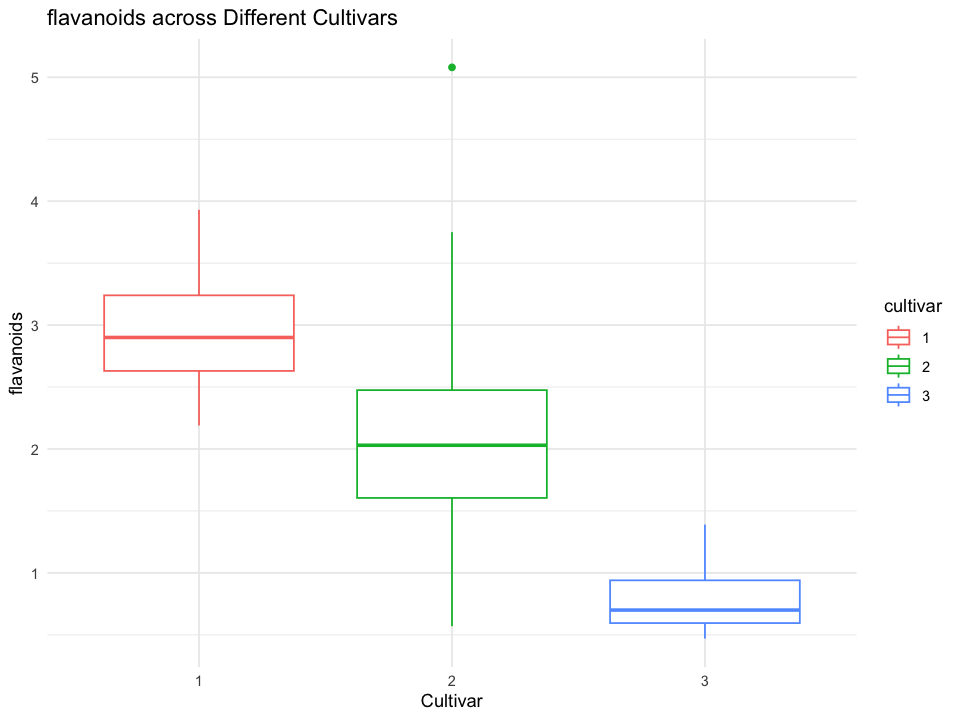

[[1]]

[[2]]

[[3]]


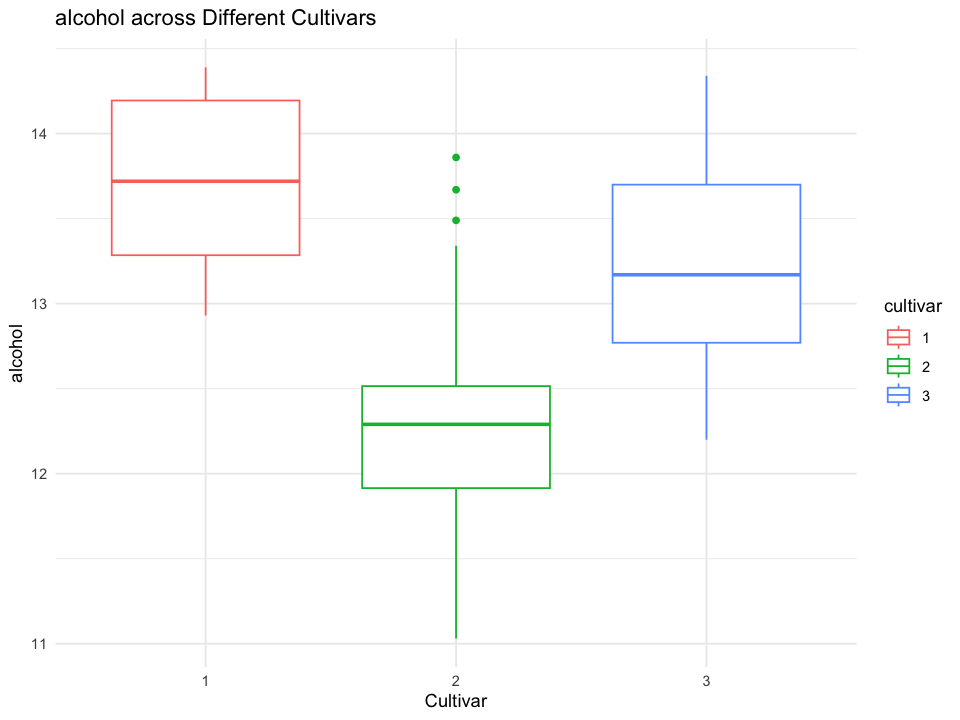

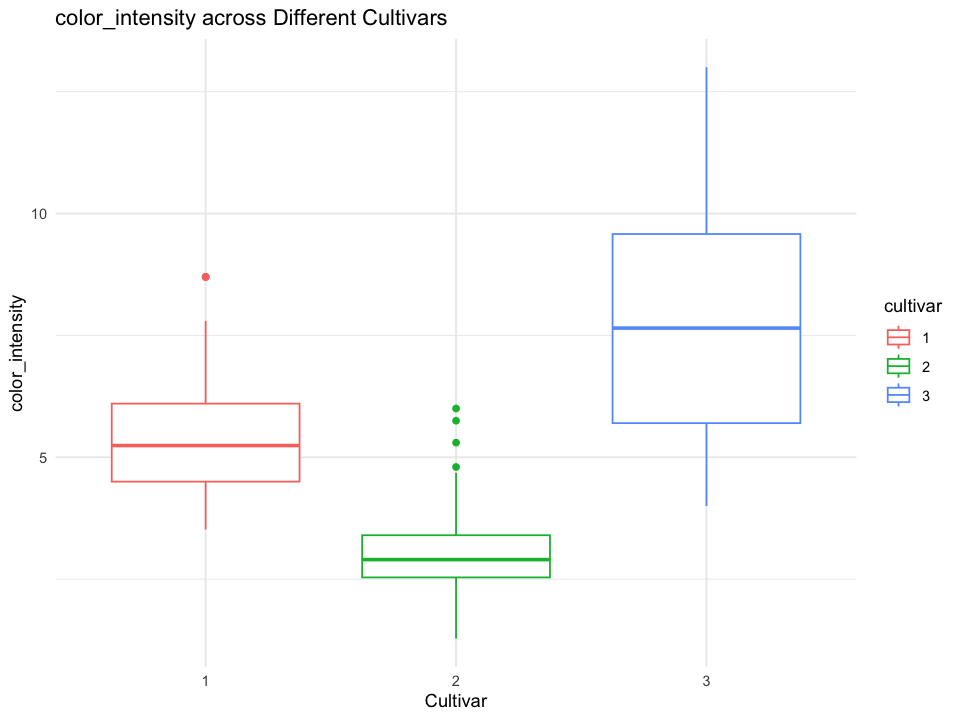

In [10]:
#Select the list of variables （"flavanoids", "alcohol", "color_intensity") to visualize and compare
variables_to_plot <- c("flavanoids", "alcohol", "color_intensity")

plots_list <- lapply(variables_to_plot, function(var) {
  ggplot(data, aes(x = cultivar, y = .data[[var]], color = cultivar)) +
    geom_boxplot() +
    labs(title = paste(var, "across Different Cultivars"), x = "Cultivar", y = var) +
    theme_minimal()
})

plots_list

Figure 4. Boxplots of flavanoids, alcohol content, and color intensity to visualize and compare the three cultivars

## K-nearest neighbours regression

In [11]:
data_split <- initial_split(data, prop = 0.75, strata = cultivar)
data_train <- training(data_split)
data_test <- testing(data_split)

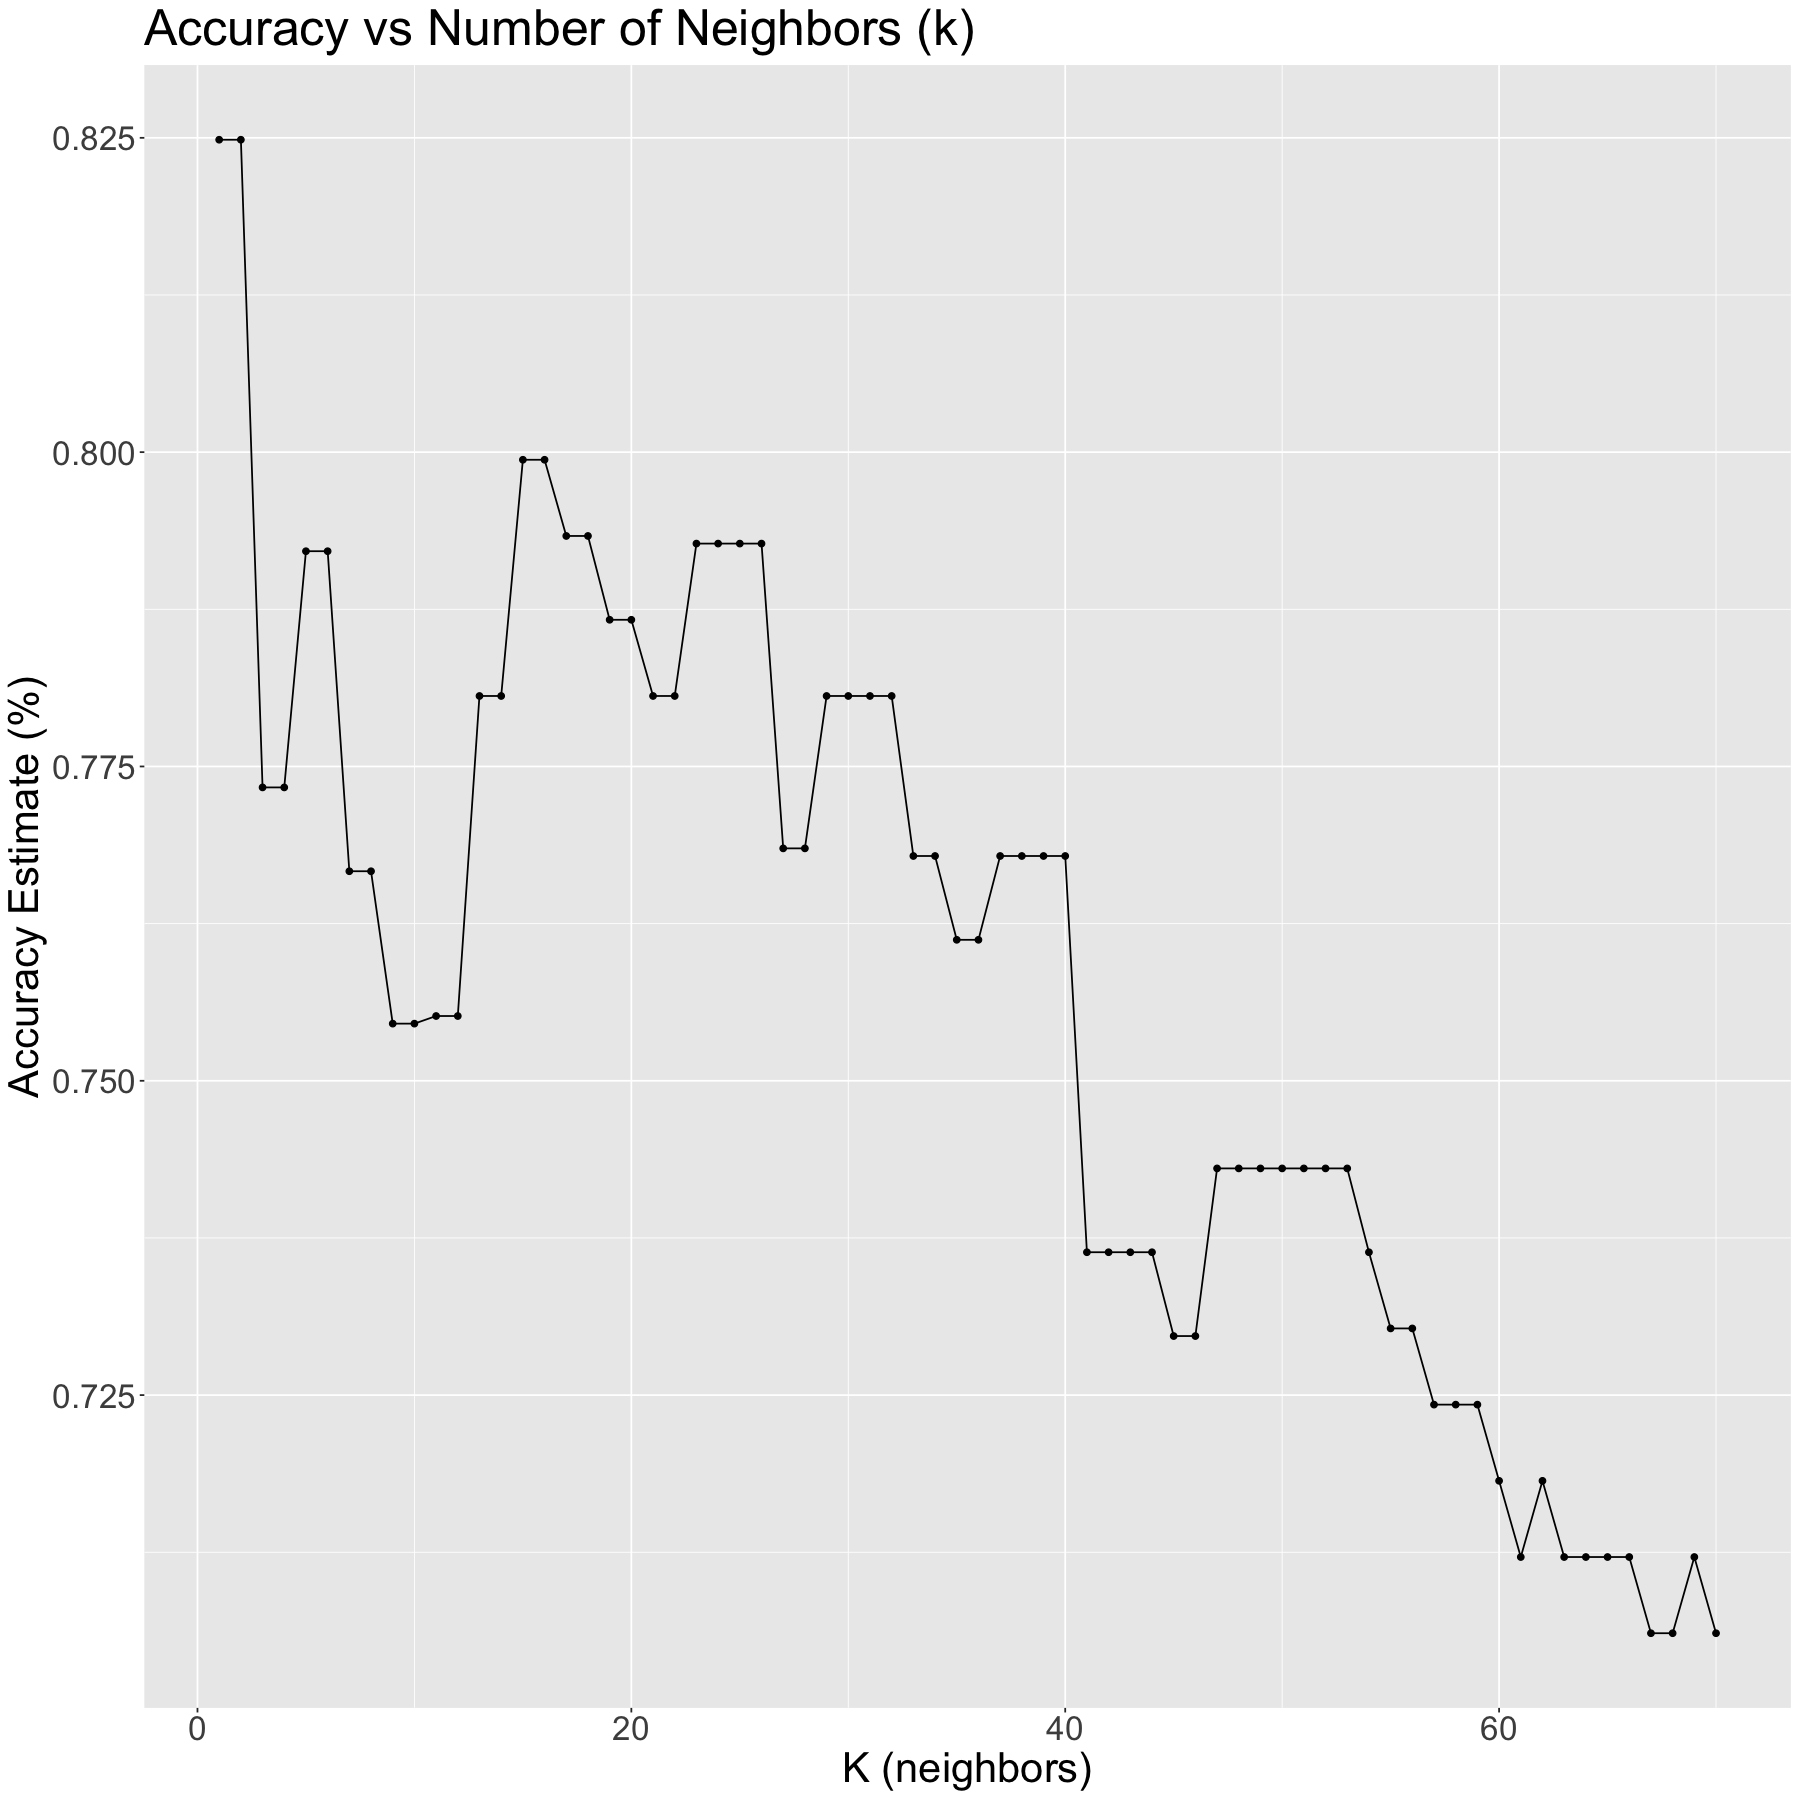

In [12]:
data_recipe <- recipe(cultivar ~ flavanoids + total_phenols, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

data_spec <- nearest_neighbor(weight_func = "rectangular",
                               neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

data_vfold <- vfold_cv(data_train, v = 5, strata = cultivar)

k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 1))

knn_results <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(data_spec) |>
    tune_grid(resamples = data_vfold, grid = k_vals) |>
    collect_metrics()

accuracies = knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K (neighbors)", y = "Accuracy Estimate (%)", title = "Accuracy vs Number of Neighbors (k)") +
    theme(text = element_text(size = 25))

options(repr.plot.width = 15, repr.plot.height = 15) # format the any visualizations to be easily viewable
cross_val_plot

Figure 3: A comparison of $k$ and accuracy.

<br>

In [13]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
    set_engine("kknn") |>
    set_mode("classification")


final_fit<-workflow()|>
        add_recipe(data_recipe)|>
        add_model(knn_spec_final)|>
        fit(data_train)
final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2012579
Best kernel: rectangular
Best k: 8

Table 4: The hyperparameters of the optimized k-nn model.

<br>

In [14]:
data_test_predictions<-predict(final_fit,data_test)|>
    bind_cols(data_test)|>
    arrange(cultivar)|>
    mutate(Class=as_factor(cultivar))

data_prediction_accuracy <- data_test_predictions |>
        metrics(truth = Class, estimate = .pred_class)|>
        filter(.metric=="accuracy")

data_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7962963


Table 5: A summary of the model's accuracy.

<br>

In [15]:
data_prediction_truth_mat<-data_test_predictions |>
        conf_mat(truth = Class, estimate = .pred_class)

data_prediction_truth_mat

          Truth
Prediction  1  2  3
         1 16  6  0
         2  2  9  0
         3  0  3 18

Table 6: A confusion matrix for the model's predictions.

<br>

<br>

## Methods & Results
---
This project utilized a K-nearest neighbours algorithm to predict what cultivar a wine was derived from based on its various chemical properties. First, we read in data from the UCI Machine Learning Repository. It contains data about various wines from Italy derived from three different cultivars. Each row represents the chemical and physical properties of a different wine, such as its concentration of alcohol, magnesium level and hue.

We then tidied the data and balanced the classes of the classification variable we are interested in. This is because the data set is not extensively large, so ensuring each class has an equal number of observations prevents our model from being biased towards a specific dominant class. Next we calculated some summary statistics to facilitate exploratory data analysis, with the goal of finding key input variables for our model.

The data was split into 75% for the training set and 25% for the test set. To fine tune our model, we used 5 fold cross validation, grid search, and graphical methods to choose the optimal value of $K$. The result was $K$ = 8 being used in the k-nn model.


<br>

## Discussion
--- 

Our multiclass k-nn model performed relatively well on the test data, achieving an accuracy estimate of approximately $80\%$. The confusion matrix reveals insights into the model's performance across the three cultivar classes. Notably, while the model demonstrated strong precision and recall for predicting cultivar 3, it encountered challenges in accurately classifying cultivar 2. This aligns with our initial hypothesis that certain chemical properties may serve as distinguishing factors for wine cultivars.

However, despite the model's overall success, its limitations in predicting cultivar 2 suggest avenues for improvement. Future iterations of the model could benefit from refining input variables to better capture the nuances of each cultivar's chemical composition. Moreover, our findings underscore the importance of further investigation into the unique characteristics of cultivar 3, which consistently stood out in our predictions.

By elucidating the chemical properties that differentiate wine cultivars, our study contributes to the broader goal of simplifying wine classification for consumers. Ultimately, this research not only enhances our understanding of wine chemistry but also has practical implications for wine enthusiasts and industry professionals alike. 

<br>

## References
---
Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.

Bai, X., Wang, L., & Li, H. (2019). Identification of red wine categories based on physicochemical properties. International Conference on Educational Technology, Management, and Humanities Science, 1443-1448.
https://doi.org/ 10.25236/etmhs.2019.30



Fehér, J., Lengyel, G., & Lugasi, A. (2007). The cultural history of wine—Theoretical background to wine therapy. Central European Journal of Medicine, 2(4), 379–391. https://doi.org/10.2478/s11536-007-0048



Harutyunyan, M., & Malfeito-Ferreira, M. (2022). The Rise of Wine among Ancient Civilizations across the Mediterranean Basin. Heritage, 5(2), Article 2. https://doi.org/10.3390/heritage50203


